<a href="https://colab.research.google.com/github/D4n1elR0drigues/TCC/blob/main/%5BMain_Code%5D_Trading_Robot_4_0_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# EXECUTAR NA PRIMEIRA EXECUÇÃO!

In [1]:
# Imports

import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
import shutil

import time

import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

# Monte o Google Drive no ambiente do Colab
drive.mount('/content/drive')


Mounted at /content/drive


<Figure size 2200x1500 with 0 Axes>

In [2]:
# Defining our Deep Q-Learning Trader

class AI_Trader():

# -----------------------------------------------------------------------

  # CONSTRUTOR

  def __init__(self, state_size, action_space=3, model_name="AITrader"):

    self.state_size = state_size # Tamanho da entrada da rede neural
    self.action_space = action_space # Espaço de ação será 3, Comprar, Vender, Sem Ação (Tamanho da saída da rede neural)
    self.memory = deque(maxlen=2000) # Memória com 2000 posições. A função Deque permite adicionar elementos ao final, enquanto remove elementos do início.
    self.inventory = [] # Terá as comprar que já fizemos
    self.model_name = model_name # Nome do modelo para o Keras

    self.gamma = 0.95 # Parâmetro que ajudará a maximizar a recompensa
    self.epsilon = 1.0 # Taxa de aleatoriedade para atitudes ganacioas do algorítimo.
    self.epsilon_final = 0.01 # Taxa final reduzida
    self.epsilon_decay = 0.995 # Velocidade de decaimento da taxa

    self.model = self.model_builder() # Inicializa um modelo e de rede neural e salva na classe

# -----------------------------------------------------------------------

  # DEFININDO A REDE NEURAL

  def model_builder(self):

    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_dim=self.state_size))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dense(units=self.action_space, activation='linear')) # De maneira geral, teremos 3 saída na rede geral (número de espaços de ação)


    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001)); # Compilamos o modelo

    return model # Retornamos o modelo pela função.

# -----------------------------------------------------------------------

  # FUNÇÃO DE TRADE
  # Usa o Epsilon e um número aleatório para definir se usará um dado aleatório ou a previsão da rede.

  def trade(self, state):
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space) # Retonar uma resposta aleatória

    actions = self.model.predict(state)
    return np.argmax(actions[0]) # Retorna o index da maior resposta da rede

# -----------------------------------------------------------------------

  # LOTE DE TREINAMENTO

  # Definindo o modelo para treinamento do lote

  def batch_train(self, batch_size): # Função que tem o tamanho do lote como argumento

    batch = [] # Iremos usar a memória como lote, por isso iniciamos com uma lista vazia

    # Iteramos sobre a memória, adicionando seus elementos ao lote batch
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])

    # Agora temos um lote de dados e devemos iterar sobre cada estado, recompensa,
    # proximo_estado e conclusão do lote e treinar o modelo com isso.
    for state, action, reward, next_state, done in batch:
      reward = reward

      # Se não estivermos no último agente da memória, então calculamos a
      # recompensa descontando a recompensa total da recompensa atual.
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

      # Fazemos uma previsão e alocamos à varivel target
      target = self.model.predict(state)
      target[0][action] = reward

      # Treinamos o modelo com o estado, usando a previsão como resultado esperado.
      self.model.fit(state, target, epochs=1, verbose=0)

    # Por fim decrementamos o epsilon a fim de gradativamente diminuir tentativas ganaciosas.
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

# -----------------------------------------------------------------------


# -----------------------------------------------------------------------


# -----------------------------------------------------------------------


# -----------------------------------------------------------------------



In [3]:
# Stock Market Data Preprocessing

# Definiremos algumas funções auxiliares

# Sigmoid
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# Função para formatar texto
def stock_price_format(n):
  if n < 0:
    return "- # {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

# Busca dados no Yahoo Finance
# Formato data = "yyyy-mm-dd"
def dataset_loader(stock_name, initial_date, final_date):

  yfin.pdr_override()

  dataset = pdr.get_data_yahoo(stock_name, start=initial_date, end=final_date)

  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[1]).split()[0]

  close = dataset['Close']

  return close

In [4]:
# State Creator


def state_creator(data, timestep, window_size):

  # O index incial (starting_id) será o timestep (passos/dias que já foram dados)
  # menos o tamanho da janela, que serão os dias olhados para trás.
  starting_id = timestep - window_size + 1


  # Lógica para preencher os dados vindos da tabela Data, no array windowed_data

  if starting_id >= 0: # No geral este será a condição sempre executada
    windowed_data = data[starting_id: timestep + 1]

  else: # Condição executada apenas nos primeiros valores
    windowed_data =- starting_id * [data[0]] + list(data[0:timestep + 1])

  state = [] # Criação de uma array para retorno, com o estado.

  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i]))

  return np.array([state])

In [1]:
# Loading a Dataset

# CONFIGURAÇÕES DE IMPORTAÇÃO DE DADOS

# NOME DA AÇÃO
STOCK_NAME = "ITUB4.SA"

# DATA INCIAL
INITIAL_DATE = "2022-01-01"

# DATA FINAL
today = datetime.date.today()
FINAL_DATE = "2023-08-20" # Escolhe a data final como hoje
#FINAL_DATE = today.strftime("%Y-%m-%d")
data = dataset_loader(STOCK_NAME, INITIAL_DATE, FINAL_DATE);

data

NameError: ignored

In [6]:
# Training the Q-Learning Trading Agent

window_size = 10
episodes = 2

batch_size = 32
data_samples = len(data) - 1

trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11171 (43.64 KB)
Trainable params: 11171 (43.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Vamos iterar sobre todos episódios

for episode in range(1, episodes + 1):

  print("Episode: {}/{}".format(episode, episodes))

  # Criamos o primeiro estado.
  state = state_creator(data, 0, window_size + 1)

  # Inicializamos algumas variáveis
  total_profit = 0
  trader.inventory = []

  # O Loop de treinamento que será executado durante uma época inteira
  for t in tqdm(range(data_samples)):

    # O IA executa a função trade, que responderá com a ação que deve ser tomada
    action = trader.trade(state)

    # Já definimos o próximo estado
    # Note que o definimos com t+1, pois estamos considerando o próximo
    # valor da ação no index da tabela de dados.
    next_state = state_creator(data, t+1, window_size + 1)

    # Sem recompensas até agora
    reward = 0

    # Sem ação
    if action == 0:
      # Apenas um print e Recompensa = 0
      print(" - Sem ação | Total de papeis no portfolio = ", len(trader.inventory))

    # Compra
    if action == 1:
      # Recompensa = 0

      # Adicionamos a ação comprada na array de portfolio
      trader.inventory.append(data[t])

      print(" - AI Trader Comprou: ", stock_price_format(data[t]))

    # Venda (Deve possuir ações no portfolio)
    elif action == 2 and len(trader.inventory) > 0:

      # Remove última ação do portfólio e a retorna
      buy_price = trader.inventory.pop(0)

      # Recompensa = lucro ou 0 se houve prejuízo.
      reward = max(data[t] - buy_price, 0)

      total_profit += data[t] - buy_price # Soma ao lucro/prejuízo total

      print(" - AI Trader Vendeu: ", stock_price_format(data[t]), " - Lucro: " + stock_price_format(data[t] - buy_price) )


    # Verifica se estamos no final de uma época
    if t == data_samples - 1:
      done = True
    else:
      done = False


    # Salvamos os dados na memória, na mesma ordem que na função BATCH_TRAIN
    trader.memory.append((state, action, reward, next_state, done))

    # Definimos que o estado atual é o próximo estado calculado anteriormente
    state = next_state

    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")


    # Se o tamanho da memória for maior que o tamanho do lote que definimos
    # Então vamos treinar a rede, passando o tamanho do lote como argumento
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)

  # A Cada 10 episódios treinados, salvamos a rede
  if episode % 2 == 0:
      model_name = "ai_trader_{}.h5".format(episode)
      trader.model.save(model_name)

      # Enviar o arquivo para o Google Drive
      source_path = model_name
      destination_path = '/content/drive/My Drive/Arquivos H5/' + model_name

      shutil.copy(source_path, destination_path)

      print('Arquivo enviado para o Google Drive com sucesso!')

Episode: 1/2


  0%|          | 0/458 [00:00<?, ?it/s]

 - Sem ação | Total de papeis no portfolio =  0
 - Sem ação | Total de papeis no portfolio =  0
 - Sem ação | Total de papeis no portfolio =  0
 - AI Trader Comprou:  $ 23.350000
 - Sem ação | Total de papeis no portfolio =  1
 - AI Trader Vendeu:  $ 23.680000  - Lucro: $ 0.330000
 - AI Trader Comprou:  $ 23.500000
 - AI Trader Comprou:  $ 23.500000
 - AI Trader Comprou:  $ 23.639999
 - Sem ação | Total de papeis no portfolio =  3
 - Sem ação | Total de papeis no portfolio =  3
 - Sem ação | Total de papeis no portfolio =  3
 - AI Trader Vendeu:  $ 23.270000  - Lucro: - # 0.230000
 - Sem ação | Total de papeis no portfolio =  2
 - Sem ação | Total de papeis no portfolio =  2
 - AI Trader Vendeu:  $ 24.490000  - Lucro: $ 0.990000
 - Sem ação | Total de papeis no portfolio =  1
 - AI Trader Comprou:  $ 25.330000
 - AI Trader Comprou:  $ 25.490000
 - AI Trader Vendeu:  $ 25.090000  - Lucro: $ 1.450001
 - AI Trader Vendeu:  $ 25.379999  - Lucro: $ 0.049999
 - Sem ação | Total de papeis no 

  7%|▋         | 33/458 [00:07<01:31,  4.64it/s]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 34/458 [00:14<03:29,  2.02it/s]

 - AI Trader Vendeu:  $ 26.170000  - Lucro: - # 0.360001
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 35/458 [00:20<05:50,  1.21it/s]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 41ms/step


  8%|▊         | 36/458 [00:27<08:51,  1.26s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 37/458 [00:33<12:16,  1.75s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 38/458 [00:39<15:53,  2.27s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 39/458 [00:46<20:29,  2.93s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 40/458 [00:52<23:54,  3.43s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 41/458 [00:59<29:11,  4.20s/it]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 42/458 [01:05<31:40,  4.57s/it]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 43/458 [01:12<35:48,  5.18s/it]

 - AI Trader Comprou:  $ 24.139999
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 44/458 [01:18<37:02,  5.37s/it]

 - AI Trader Vendeu:  $ 23.910000  - Lucro: - # 0.230000
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 45/458 [01:26<41:18,  6.00s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 10%|█         | 46/458 [01:32<41:28,  6.04s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 47/458 [01:39<43:23,  6.33s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 48/458 [01:45<42:08,  6.17s/it]

 - AI Trader Comprou:  $ 25.190001
1/1 [==============================] - 0s 19ms/step


 11%|█         | 49/458 [01:52<43:59,  6.45s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Vendeu:  $ 25.100000  - Lucro: - # 0.090000
1/1 [==============================] - 0s 22ms/step


 11%|█         | 50/458 [01:58<42:43,  6.28s/it]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 51/458 [02:05<44:00,  6.49s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 52/458 [02:11<43:21,  6.41s/it]

 - AI Trader Comprou:  $ 26.340000
1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 53/458 [02:17<43:33,  6.45s/it]

 - AI Trader Vendeu:  $ 26.990000  - Lucro: $ 0.650000
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 54/458 [02:25<45:02,  6.69s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 55/458 [02:32<46:30,  6.92s/it]

 - AI Trader Comprou:  $ 27.240000
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 56/458 [02:39<45:17,  6.76s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 57/458 [02:45<44:51,  6.71s/it]

 - AI Trader Vendeu:  $ 27.469999  - Lucro: $ 0.230000
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 58/458 [02:52<44:38,  6.70s/it]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 59/458 [02:58<43:24,  6.53s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 60/458 [03:05<44:18,  6.68s/it]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 61/458 [03:11<42:43,  6.46s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 62/458 [03:18<44:16,  6.71s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 63/458 [03:24<42:32,  6.46s/it]

 - AI Trader Comprou:  $ 27.290001
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 64/458 [03:32<45:02,  6.86s/it]

 - AI Trader Comprou:  $ 26.740000
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 65/458 [03:38<44:20,  6.77s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 66/458 [03:46<45:02,  6.89s/it]

 - AI Trader Vendeu:  $ 26.709999  - Lucro: - # 0.580002
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 67/458 [03:52<43:04,  6.61s/it]

 - AI Trader Vendeu:  $ 26.660000  - Lucro: - # 0.080000
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 68/458 [03:59<44:11,  6.80s/it]

 - AI Trader Comprou:  $ 26.559999
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 69/458 [04:05<42:39,  6.58s/it]

1/1 [==============================] - 0s 24ms/step
 - AI Trader Vendeu:  $ 26.090000  - Lucro: - # 0.469999
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 70/458 [04:12<43:55,  6.79s/it]

 - AI Trader Comprou:  $ 26.160000
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 71/458 [04:18<42:00,  6.51s/it]

 - AI Trader Comprou:  $ 26.330000
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 72/458 [04:25<43:22,  6.74s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 73/458 [04:31<41:36,  6.48s/it]

 - AI Trader Comprou:  $ 26.010000
1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 74/458 [04:39<43:48,  6.85s/it]

1/1 [==============================] - 0s 42ms/step
 - AI Trader Vendeu:  $ 26.180000  - Lucro: $ 0.020000
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 75/458 [04:46<43:40,  6.84s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 76/458 [04:53<44:43,  7.02s/it]

 - AI Trader Vendeu:  $ 25.570000  - Lucro: - # 0.760000
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 77/458 [04:59<42:40,  6.72s/it]

 - AI Trader Comprou:  $ 24.700001
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 78/458 [05:06<42:55,  6.78s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 79/458 [05:12<42:03,  6.66s/it]

 - AI Trader Comprou:  $ 24.299999
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 80/458 [05:19<41:56,  6.66s/it]

 - AI Trader Comprou:  $ 23.870001
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 81/458 [05:26<41:57,  6.68s/it]

 - AI Trader Vendeu:  $ 23.750000  - Lucro: - # 2.260000
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 82/458 [05:32<41:12,  6.58s/it]

 - Sem ação | Total de papeis no portfolio =  3
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 83/458 [05:39<41:59,  6.72s/it]

 - AI Trader Comprou:  $ 23.840000
1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 84/458 [05:46<42:12,  6.77s/it]

 - AI Trader Vendeu:  $ 23.290001  - Lucro: - # 1.410000
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 85/458 [05:54<43:40,  7.02s/it]

 - AI Trader Comprou:  $ 23.790001
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 86/458 [06:00<42:41,  6.88s/it]

 - AI Trader Vendeu:  $ 23.450001  - Lucro: - # 0.849998
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 87/458 [06:07<43:01,  6.96s/it]

 - AI Trader Vendeu:  $ 23.330000  - Lucro: - # 0.540001
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 88/458 [06:14<41:23,  6.71s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Vendeu:  $ 24.110001  - Lucro: $ 0.270000
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 89/458 [06:21<42:30,  6.91s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 90/458 [06:27<40:46,  6.65s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Vendeu:  $ 24.780001  - Lucro: $ 0.990000
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 91/458 [06:34<42:09,  6.89s/it]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 92/458 [06:41<40:35,  6.65s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 93/458 [06:48<41:43,  6.86s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 94/458 [06:55<42:08,  6.95s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 95/458 [07:03<43:16,  7.15s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 96/458 [07:09<41:12,  6.83s/it]

 - AI Trader Comprou:  $ 25.780001
1/1 [==============================] - 0s 22ms/step


 21%|██        | 97/458 [07:16<42:09,  7.01s/it]

 - AI Trader Vendeu:  $ 26.170000  - Lucro: $ 0.389999
1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 98/458 [07:22<40:28,  6.75s/it]

 - AI Trader Comprou:  $ 25.700001
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 99/458 [07:30<41:39,  6.96s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 100/458 [07:36<39:57,  6.70s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 101/458 [07:43<41:17,  6.94s/it]

 - AI Trader Comprou:  $ 25.920000
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 102/458 [07:49<39:35,  6.67s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 103/458 [07:57<40:50,  6.90s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 25.780001
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 104/458 [08:04<41:25,  7.02s/it]

 - AI Trader Vendeu:  $ 25.889999  - Lucro: $ 0.189999
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 105/458 [08:12<42:02,  7.15s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 106/458 [08:18<40:06,  6.84s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 107/458 [08:25<40:56,  7.00s/it]

 - AI Trader Vendeu:  $ 25.559999  - Lucro: - # 0.360001
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 108/458 [08:31<39:12,  6.72s/it]

 - AI Trader Comprou:  $ 25.070000
1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 109/458 [08:39<40:13,  6.92s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 110/458 [08:45<38:40,  6.67s/it]

 - AI Trader Vendeu:  $ 24.100000  - Lucro: - # 1.680000
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 111/458 [08:52<39:26,  6.82s/it]

 - AI Trader Comprou:  $ 23.809999
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 112/458 [08:58<38:37,  6.70s/it]

 - AI Trader Vendeu:  $ 23.650000  - Lucro: - # 1.420000
1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 113/458 [09:05<38:54,  6.77s/it]

 - AI Trader Vendeu:  $ 23.750000  - Lucro: - # 0.059999
1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 114/458 [09:13<40:40,  7.09s/it]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 115/458 [09:20<41:05,  7.19s/it]

 - AI Trader Comprou:  $ 24.469999
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 116/458 [09:27<39:41,  6.96s/it]

 - AI Trader Comprou:  $ 24.209999
1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 117/458 [09:34<39:14,  6.90s/it]

 - AI Trader Comprou:  $ 24.030001
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 118/458 [09:40<38:41,  6.83s/it]

 - AI Trader Comprou:  $ 23.480000
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 119/458 [09:47<38:17,  6.78s/it]

 - AI Trader Vendeu:  $ 23.440001  - Lucro: - # 1.029999
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 120/458 [09:54<38:28,  6.83s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 23.580000  - Lucro: - # 0.629999
1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 121/458 [10:00<37:56,  6.76s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 23.320000
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 122/458 [10:08<38:38,  6.90s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 23.080000  - Lucro: - # 0.950001
1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 123/458 [10:15<38:55,  6.97s/it]

1/1 [==============================] - 0s 37ms/step
 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 124/458 [10:22<39:54,  7.17s/it]

 - AI Trader Vendeu:  $ 22.850000  - Lucro: - # 0.629999
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 125/458 [10:29<38:52,  7.01s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 126/458 [10:36<38:50,  7.02s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 22.790001  - Lucro: - # 0.529999
1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 127/458 [10:43<37:51,  6.86s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 128/458 [10:50<38:41,  7.04s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 129/458 [10:56<37:29,  6.84s/it]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 130/458 [11:04<38:28,  7.04s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 131/458 [11:10<37:07,  6.81s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 132/458 [11:18<38:17,  7.05s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 133/458 [11:25<38:41,  7.14s/it]

 - AI Trader Comprou:  $ 22.150000
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 134/458 [11:33<39:04,  7.24s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 22.549999  - Lucro: $ 0.400000
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 135/458 [11:39<37:45,  7.01s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 136/458 [11:46<38:10,  7.11s/it]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 137/458 [11:53<36:40,  6.85s/it]

 - AI Trader Comprou:  $ 23.320000
1/1 [==============================] - 0s 19ms/step


 30%|███       | 138/458 [12:00<37:41,  7.07s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 23.510000  - Lucro: $ 0.190001
1/1 [==============================] - 0s 21ms/step


 30%|███       | 139/458 [12:07<36:24,  6.85s/it]

 - AI Trader Comprou:  $ 23.260000
1/1 [==============================] - 0s 22ms/step


 31%|███       | 140/458 [12:14<37:31,  7.08s/it]

 - AI Trader Comprou:  $ 23.600000
1/1 [==============================] - 0s 22ms/step


 31%|███       | 141/458 [12:20<35:59,  6.81s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 19ms/step


 31%|███       | 142/458 [12:28<37:15,  7.07s/it]

 - AI Trader Vendeu:  $ 23.549999  - Lucro: $ 0.289999
1/1 [==============================] - 0s 20ms/step


 31%|███       | 143/458 [12:35<37:36,  7.16s/it]

 - AI Trader Comprou:  $ 23.700001
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 144/458 [12:43<38:22,  7.33s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 145/458 [12:50<36:54,  7.08s/it]

1/1 [==============================] - 0s 33ms/step
 - AI Trader Vendeu:  $ 23.469999  - Lucro: - # 0.130001
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 146/458 [12:57<37:50,  7.28s/it]

 - AI Trader Vendeu:  $ 23.719999  - Lucro: $ 0.019999
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 147/458 [13:04<36:11,  6.98s/it]

 - AI Trader Comprou:  $ 23.889999
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 148/458 [13:11<37:15,  7.21s/it]

 - AI Trader Vendeu:  $ 24.469999  - Lucro: $ 0.580000
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 149/458 [13:18<35:43,  6.94s/it]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 150/458 [13:26<37:00,  7.21s/it]

 - AI Trader Comprou:  $ 25.240000
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 151/458 [13:32<35:28,  6.93s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 25.900000  - Lucro: $ 0.660000
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 152/458 [13:40<37:41,  7.39s/it]

 - AI Trader Comprou:  $ 26.379999
1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 153/458 [13:47<36:56,  7.27s/it]

 - AI Trader Comprou:  $ 26.420000
1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 154/458 [13:55<37:20,  7.37s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 155/458 [14:01<35:28,  7.02s/it]

 - AI Trader Comprou:  $ 26.969999
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 156/458 [14:09<36:14,  7.20s/it]

 - AI Trader Comprou:  $ 27.280001
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 157/458 [14:15<34:45,  6.93s/it]

 - AI Trader Comprou:  $ 27.350000
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 158/458 [14:23<35:53,  7.18s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 27.270000  - Lucro: $ 0.890001
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 159/458 [14:29<34:47,  6.98s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.639999  - Lucro: $ 0.219999
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 160/458 [14:37<35:59,  7.25s/it]

 - Sem ação | Total de papeis no portfolio =  3
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 161/458 [14:44<34:39,  7.00s/it]

 - AI Trader Vendeu:  $ 26.410000  - Lucro: - # 0.559999
1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 162/458 [14:52<36:57,  7.49s/it]

1/1 [==============================] - 0s 27ms/step
 - AI Trader Vendeu:  $ 26.520000  - Lucro: - # 0.760000
1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 163/458 [14:59<36:13,  7.37s/it]

1/1 [==============================] - 0s 28ms/step
 - AI Trader Vendeu:  $ 26.850000  - Lucro: - # 0.500000
1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 164/458 [15:07<36:30,  7.45s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 165/458 [15:14<34:59,  7.17s/it]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 166/458 [15:21<35:33,  7.31s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 167/458 [15:28<34:19,  7.08s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 168/458 [15:35<35:13,  7.29s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 169/458 [15:42<33:59,  7.06s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 170/458 [15:50<34:48,  7.25s/it]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 171/458 [15:57<34:52,  7.29s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 172/458 [16:05<35:52,  7.53s/it]

 - AI Trader Comprou:  $ 26.540001
1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 173/458 [16:12<34:59,  7.37s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 174/458 [16:19<34:23,  7.26s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 27.080000  - Lucro: $ 0.539999
1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 175/458 [16:26<33:38,  7.13s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 176/458 [16:33<33:51,  7.21s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 177/458 [16:40<33:05,  7.07s/it]

1/1 [==============================] - 0s 32ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 178/458 [16:48<33:35,  7.20s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 179/458 [16:55<33:20,  7.17s/it]

1/1 [==============================] - 0s 31ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 180/458 [17:02<33:30,  7.23s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 181/458 [17:10<34:35,  7.49s/it]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 182/458 [17:17<33:50,  7.36s/it]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 183/458 [17:25<33:53,  7.39s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 184/458 [17:32<32:58,  7.22s/it]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 185/458 [17:39<32:41,  7.19s/it]

 - AI Trader Comprou:  $ 27.530001
1/1 [==============================] - 0s 21ms/step


 41%|████      | 186/458 [17:46<32:26,  7.16s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 32ms/step


 41%|████      | 187/458 [17:53<32:08,  7.12s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 19ms/step


 41%|████      | 188/458 [18:00<31:58,  7.11s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.059999  - Lucro: $ 0.529999
1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 189/458 [18:07<31:24,  7.00s/it]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 190/458 [18:14<31:42,  7.10s/it]

 - AI Trader Comprou:  $ 29.799999
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 191/458 [18:22<33:14,  7.47s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 192/458 [18:29<32:29,  7.33s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Vendeu:  $ 29.260000  - Lucro: - # 0.539999
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 193/458 [18:36<32:10,  7.29s/it]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 194/458 [18:43<31:37,  7.19s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 29.010000
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 195/458 [18:51<31:49,  7.26s/it]

1/1 [==============================] - 0s 29ms/step
 - AI Trader Vendeu:  $ 28.809999  - Lucro: - # 0.200001
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 196/458 [18:58<31:30,  7.21s/it]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 197/458 [19:05<31:32,  7.25s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 198/458 [19:12<31:07,  7.18s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 199/458 [19:19<30:52,  7.15s/it]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 200/458 [19:27<31:57,  7.43s/it]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 201/458 [19:35<32:32,  7.60s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 202/458 [19:42<31:02,  7.28s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 203/458 [19:49<31:09,  7.33s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 204/458 [19:56<30:22,  7.18s/it]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 205/458 [20:04<30:50,  7.31s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 206/458 [20:11<30:02,  7.15s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 207/458 [20:18<30:26,  7.28s/it]

1/1 [==============================] - 0s 34ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 208/458 [20:25<29:39,  7.12s/it]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 209/458 [20:32<30:00,  7.23s/it]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 210/458 [20:40<30:34,  7.40s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 211/458 [20:48<31:13,  7.58s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 30.350000
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 212/458 [20:55<29:50,  7.28s/it]

 - AI Trader Comprou:  $ 29.660000
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 213/458 [21:03<30:30,  7.47s/it]

 - AI Trader Comprou:  $ 29.570000
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 214/458 [21:09<29:12,  7.18s/it]

 - AI Trader Vendeu:  $ 28.150000  - Lucro: - # 2.200001
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 215/458 [21:17<30:02,  7.42s/it]

1/1 [==============================] - 0s 28ms/step
 - AI Trader Vendeu:  $ 27.620001  - Lucro: - # 2.039999
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 216/458 [21:24<28:53,  7.16s/it]

 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 217/458 [21:32<29:40,  7.39s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 218/458 [21:38<28:40,  7.17s/it]

 - AI Trader Comprou:  $ 26.270000
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 219/458 [21:47<30:12,  7.58s/it]

 - AI Trader Vendeu:  $ 26.430000  - Lucro: - # 3.139999
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 220/458 [21:54<29:06,  7.34s/it]

1/1 [==============================] - 0s 24ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 221/458 [22:02<29:41,  7.52s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 222/458 [22:08<28:12,  7.17s/it]

 - AI Trader Vendeu:  $ 26.280001  - Lucro: $ 0.010000
1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 223/458 [22:16<28:54,  7.38s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 224/458 [22:22<27:53,  7.15s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 225/458 [22:30<28:40,  7.39s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 226/458 [22:37<27:39,  7.15s/it]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 227/458 [22:45<28:28,  7.40s/it]

 - AI Trader Comprou:  $ 25.740000
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 228/458 [22:52<27:23,  7.15s/it]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 29ms/step


 50%|█████     | 229/458 [23:01<29:43,  7.79s/it]

 - AI Trader Vendeu:  $ 25.980000  - Lucro: $ 0.240000
1/1 [==============================] - 0s 18ms/step


 50%|█████     | 230/458 [23:07<28:18,  7.45s/it]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 231/458 [23:16<28:52,  7.63s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 232/458 [23:22<27:37,  7.33s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 233/458 [23:30<28:15,  7.54s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 234/458 [23:37<27:06,  7.26s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 235/458 [23:45<27:47,  7.48s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 236/458 [23:51<26:41,  7.21s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 237/458 [24:00<27:36,  7.49s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 238/458 [24:07<27:40,  7.55s/it]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 239/458 [24:15<27:57,  7.66s/it]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 240/458 [24:22<27:17,  7.51s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 241/458 [24:30<27:04,  7.49s/it]

 - AI Trader Comprou:  $ 24.389999
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 242/458 [24:37<26:15,  7.30s/it]

 - AI Trader Vendeu:  $ 24.650000  - Lucro: $ 0.260000
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 243/458 [24:44<26:21,  7.36s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 244/458 [24:51<26:05,  7.32s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 245/458 [24:59<26:09,  7.37s/it]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 246/458 [25:06<25:54,  7.33s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 247/458 [25:14<25:59,  7.39s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 24.549999
1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 248/458 [25:22<26:59,  7.71s/it]

1/1 [==============================] - 0s 33ms/step
 - AI Trader Comprou:  $ 25.049999
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 249/458 [25:30<26:38,  7.65s/it]

 - AI Trader Comprou:  $ 25.000000
1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 250/458 [25:38<26:52,  7.75s/it]

 - AI Trader Vendeu:  $ 24.490000  - Lucro: - # 0.059999
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 251/458 [25:44<25:47,  7.48s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 23.980000
1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 252/458 [25:52<26:21,  7.68s/it]

1/1 [==============================] - 0s 34ms/step
 - AI Trader Comprou:  $ 24.049999
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 253/458 [25:59<25:21,  7.42s/it]

 - AI Trader Comprou:  $ 24.799999
1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 254/458 [26:07<25:56,  7.63s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 25.230000  - Lucro: $ 0.180000
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 255/458 [26:14<24:55,  7.36s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 25.410000  - Lucro: $ 0.410000
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 256/458 [26:22<25:34,  7.60s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 25.900000  - Lucro: $ 1.920000
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 257/458 [26:30<25:05,  7.49s/it]

 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 258/458 [26:38<26:04,  7.82s/it]

 - AI Trader Vendeu:  $ 25.980000  - Lucro: $ 1.930000
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 259/458 [26:45<24:46,  7.47s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 25.850000  - Lucro: $ 1.050001
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 260/458 [26:53<25:20,  7.68s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 261/458 [27:00<24:12,  7.38s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 262/458 [27:08<24:52,  7.61s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 26.570000
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 263/458 [27:14<23:44,  7.31s/it]

 - AI Trader Vendeu:  $ 26.570000  - Lucro: $ 0.000000
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 264/458 [27:22<24:23,  7.54s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 265/458 [27:29<23:20,  7.25s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 266/458 [27:37<23:48,  7.44s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 267/458 [27:45<23:48,  7.48s/it]

1/1 [==============================] - 0s 24ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 268/458 [27:53<24:32,  7.75s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 269/458 [27:59<23:16,  7.39s/it]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 270/458 [28:08<23:47,  7.59s/it]

1/1 [==============================] - 0s 26ms/step
 - AI Trader Comprou:  $ 24.940001
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 271/458 [28:14<22:48,  7.32s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 25.330000
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 272/458 [28:22<23:20,  7.53s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 24.980000
1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 273/458 [28:29<22:17,  7.23s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 25.209999  - Lucro: $ 0.269999
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 274/458 [28:37<22:59,  7.50s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 25.120001  - Lucro: - # 0.209999
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 275/458 [28:43<21:54,  7.19s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 25.129999  - Lucro: $ 0.150000
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 276/458 [28:52<23:06,  7.62s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Comprou:  $ 24.549999
1/1 [==============================] - 0s 27ms/step


 60%|██████    | 277/458 [28:59<22:25,  7.43s/it]

1/1 [==============================] - 0s 38ms/step
 - AI Trader Vendeu:  $ 26.580000  - Lucro: $ 2.030001
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 278/458 [29:07<22:44,  7.58s/it]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 279/458 [29:13<21:43,  7.28s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 280/458 [29:21<22:11,  7.48s/it]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 281/458 [29:28<21:23,  7.25s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 282/458 [29:36<21:57,  7.48s/it]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 283/458 [29:43<21:13,  7.28s/it]

1/1 [==============================] - 0s 42ms/step
 - AI Trader Comprou:  $ 26.969999
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 284/458 [29:51<21:55,  7.56s/it]

 - AI Trader Vendeu:  $ 26.879999  - Lucro: - # 0.090000
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 285/458 [29:58<21:01,  7.29s/it]

 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 286/458 [30:07<22:28,  7.84s/it]

 - AI Trader Comprou:  $ 26.480000
1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 287/458 [30:14<22:05,  7.75s/it]

1/1 [==============================] - 0s 32ms/step
 - AI Trader Comprou:  $ 25.670000
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 288/458 [30:22<21:49,  7.70s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 25.340000
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 289/458 [30:29<21:17,  7.56s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 25.430000
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 290/458 [30:37<21:17,  7.61s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 25.000000
1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 291/458 [30:44<20:57,  7.53s/it]

 - Sem ação | Total de papeis no portfolio =  5
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 292/458 [30:52<20:51,  7.54s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 24.209999
1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 293/458 [30:59<20:29,  7.45s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 24.760000
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 294/458 [31:07<20:29,  7.50s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 24.830000
1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 295/458 [31:14<20:30,  7.55s/it]

1/1 [==============================] - 0s 34ms/step
 - AI Trader Comprou:  $ 25.139999
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 296/458 [31:23<20:49,  7.71s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 24.660000
1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 297/458 [31:30<20:45,  7.74s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 24.070000
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 298/458 [31:37<20:04,  7.53s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 23.780001
1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 299/458 [31:45<20:13,  7.63s/it]

 - AI Trader Vendeu:  $ 23.700001  - Lucro: - # 2.779999
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 300/458 [31:52<19:38,  7.46s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 23.639999
1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 301/458 [32:00<19:55,  7.62s/it]

1/1 [==============================] - 0s 37ms/step
 - AI Trader Comprou:  $ 24.030001
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 302/458 [32:07<19:18,  7.43s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 23.340000
1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 303/458 [32:15<19:37,  7.60s/it]

 - AI Trader Comprou:  $ 23.400000
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 304/458 [32:22<19:00,  7.41s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 23.879999
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 305/458 [32:31<20:07,  7.89s/it]

 - Sem ação | Total de papeis no portfolio =  16
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 306/458 [32:38<19:13,  7.59s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 23.150000
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 307/458 [32:46<19:36,  7.79s/it]

 - AI Trader Comprou:  $ 23.219999
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 308/458 [32:53<18:39,  7.46s/it]

 - AI Trader Vendeu:  $ 23.620001  - Lucro: - # 2.049999
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 309/458 [33:01<19:03,  7.67s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 23.730000
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 310/458 [33:08<18:10,  7.37s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 23.959999
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 311/458 [33:16<18:34,  7.58s/it]

 - AI Trader Vendeu:  $ 24.620001  - Lucro: - # 0.719999
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 312/458 [33:23<17:44,  7.29s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Comprou:  $ 24.740000
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 313/458 [33:31<18:16,  7.56s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 24.030001
1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 314/458 [33:37<17:27,  7.27s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 24.510000
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 315/458 [33:46<18:33,  7.79s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 24.490000
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 316/458 [33:53<17:38,  7.46s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Comprou:  $ 24.410000
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 317/458 [34:01<18:02,  7.67s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 24.670000
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 318/458 [34:08<17:15,  7.39s/it]

1/1 [==============================] - 0s 18ms/step
 - AI Trader Comprou:  $ 25.469999
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 319/458 [34:16<17:37,  7.61s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 25.639999
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 320/458 [34:23<16:50,  7.32s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.639999
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 321/458 [34:31<17:15,  7.56s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 26.010000
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 322/458 [34:37<16:28,  7.27s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 25.959999
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 323/458 [34:46<16:55,  7.52s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 25.940001
1/1 [==============================] - 0s 26ms/step


 71%|███████   | 324/458 [34:53<16:44,  7.49s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Comprou:  $ 25.530001
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 325/458 [35:02<17:21,  7.83s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 25.600000
1/1 [==============================] - 0s 30ms/step


 71%|███████   | 326/458 [35:08<16:30,  7.51s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 25.370001
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 327/458 [35:17<16:50,  7.71s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.600000
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 328/458 [35:24<16:12,  7.48s/it]

1/1 [==============================] - 0s 32ms/step
 - AI Trader Comprou:  $ 25.340000
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 329/458 [35:32<16:27,  7.66s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.790001
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 330/458 [35:39<15:53,  7.45s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 25.920000
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 331/458 [35:47<16:09,  7.63s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 24.900000
1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 332/458 [35:54<15:42,  7.48s/it]

 - AI Trader Comprou:  $ 24.860001
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 333/458 [36:02<15:55,  7.65s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.059999
1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 334/458 [36:10<16:14,  7.86s/it]

 - Sem ação | Total de papeis no portfolio =  40
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 335/458 [36:18<15:56,  7.78s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 26.350000
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 336/458 [36:25<15:34,  7.66s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 26.510000
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 337/458 [36:33<15:20,  7.61s/it]

1/1 [==============================] - 0s 19ms/step
 - Sem ação | Total de papeis no portfolio =  42
1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 338/458 [36:40<15:09,  7.58s/it]

1/1 [==============================] - 0s 32ms/step
 - AI Trader Comprou:  $ 27.160000
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 339/458 [36:48<15:01,  7.57s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 26.910000
1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 340/458 [36:55<14:52,  7.56s/it]

 - AI Trader Vendeu:  $ 27.010000  - Lucro: $ 1.580000
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 341/458 [37:03<14:42,  7.54s/it]

 - AI Trader Comprou:  $ 26.920000
1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 342/458 [37:10<14:37,  7.57s/it]

1/1 [==============================] - 0s 33ms/step
 - AI Trader Vendeu:  $ 27.190001  - Lucro: $ 2.190001
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 343/458 [37:18<14:28,  7.55s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 27.090000
1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 344/458 [37:27<15:18,  8.06s/it]

 - AI Trader Vendeu:  $ 26.870001  - Lucro: $ 2.660002
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 345/458 [37:34<14:23,  7.64s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 26.360001  - Lucro: $ 1.600000
1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 346/458 [37:42<14:32,  7.79s/it]

1/1 [==============================] - 0s 28ms/step
 - AI Trader Vendeu:  $ 26.570000  - Lucro: $ 1.740000
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 347/458 [37:49<13:52,  7.50s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Vendeu:  $ 26.420000  - Lucro: $ 1.280001
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 348/458 [37:57<14:12,  7.75s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 27.250000  - Lucro: $ 2.590000
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 349/458 [38:04<13:35,  7.48s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 27.040001  - Lucro: $ 2.970001
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 350/458 [38:12<13:53,  7.72s/it]

1/1 [==============================] - 0s 23ms/step
 - AI Trader Vendeu:  $ 26.920000  - Lucro: $ 3.139999
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 351/458 [38:19<13:12,  7.41s/it]

 - AI Trader Comprou:  $ 26.540001
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 352/458 [38:27<13:30,  7.65s/it]

 - Sem ação | Total de papeis no portfolio =  38
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 353/458 [38:34<13:16,  7.59s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 26.700001  - Lucro: $ 3.060001
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 354/458 [38:43<13:35,  7.84s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 27.090000  - Lucro: $ 3.059999
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 355/458 [38:50<12:55,  7.53s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 27.150000  - Lucro: $ 3.809999
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 356/458 [38:58<13:14,  7.79s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 27.340000  - Lucro: $ 3.940001
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 357/458 [39:05<12:38,  7.51s/it]

 - Sem ação | Total de papeis no portfolio =  34
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 358/458 [39:13<12:52,  7.73s/it]

1/1 [==============================] - 0s 24ms/step
 - AI Trader Vendeu:  $ 27.799999  - Lucro: $ 3.920000
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 359/458 [39:20<12:19,  7.47s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 27.500000  - Lucro: $ 4.350000
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 360/458 [39:28<12:39,  7.75s/it]

1/1 [==============================] - 0s 29ms/step
 - AI Trader Vendeu:  $ 27.809999  - Lucro: $ 4.590000
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 361/458 [39:35<12:03,  7.46s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 28.190001  - Lucro: $ 4.460001
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 362/458 [39:44<12:30,  7.82s/it]

1/1 [==============================] - 0s 27ms/step
 - AI Trader Vendeu:  $ 28.559999  - Lucro: $ 4.600000
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 363/458 [39:51<12:14,  7.73s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 28.650000  - Lucro: $ 3.910000
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 364/458 [40:00<12:28,  7.96s/it]

 - Sem ação | Total de papeis no portfolio =  28
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 365/458 [40:07<11:45,  7.58s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.760000  - Lucro: $ 4.730000
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 366/458 [40:15<11:58,  7.81s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 29.040001  - Lucro: $ 4.530001
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 367/458 [40:22<11:26,  7.55s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 28.760000  - Lucro: $ 4.270000
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 368/458 [40:30<11:45,  7.84s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.670000  - Lucro: $ 4.260000
1/1 [==============================] - 0s 41ms/step


 81%|████████  | 369/458 [40:37<11:14,  7.58s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Vendeu:  $ 28.629999  - Lucro: $ 3.959999
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 370/458 [40:46<11:26,  7.80s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Vendeu:  $ 28.309999  - Lucro: $ 2.840000
1/1 [==============================] - 0s 36ms/step


 81%|████████  | 371/458 [40:53<10:59,  7.58s/it]

 - AI Trader Vendeu:  $ 28.150000  - Lucro: $ 2.510000
1/1 [==============================] - 0s 29ms/step


 81%|████████  | 372/458 [41:02<11:28,  8.00s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Vendeu:  $ 28.490000  - Lucro: $ 2.850000
1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 373/458 [41:10<11:14,  7.93s/it]

1/1 [==============================] - 0s 41ms/step
 - AI Trader Vendeu:  $ 28.420000  - Lucro: $ 2.410000
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 374/458 [41:17<10:59,  7.85s/it]

1/1 [==============================] - 0s 23ms/step
 - AI Trader Vendeu:  $ 28.959999  - Lucro: $ 3.000000
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 375/458 [41:25<10:46,  7.79s/it]

1/1 [==============================] - 0s 28ms/step
 - AI Trader Vendeu:  $ 28.780001  - Lucro: $ 2.840000
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 376/458 [41:33<10:35,  7.75s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 29.030001  - Lucro: $ 3.500000
1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 377/458 [41:40<10:30,  7.78s/it]

1/1 [==============================] - 0s 37ms/step
 - AI Trader Vendeu:  $ 28.600000  - Lucro: $ 3.000000
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 378/458 [41:48<10:13,  7.67s/it]

 - Sem ação | Total de papeis no portfolio =  15
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 379/458 [41:56<10:07,  7.69s/it]

 - Sem ação | Total de papeis no portfolio =  15
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 380/458 [42:03<09:52,  7.60s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.440001  - Lucro: $ 3.070000
1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 381/458 [42:11<09:58,  7.77s/it]

1/1 [==============================] - 0s 37ms/step
 - AI Trader Vendeu:  $ 28.270000  - Lucro: $ 2.670000
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 382/458 [42:19<09:55,  7.84s/it]

1/1 [==============================] - 0s 24ms/step
 - AI Trader Vendeu:  $ 28.580000  - Lucro: $ 3.240000
1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 383/458 [42:27<09:55,  7.95s/it]

1/1 [==============================] - 0s 37ms/step
 - AI Trader Vendeu:  $ 28.280001  - Lucro: $ 2.490000
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 384/458 [42:34<09:27,  7.66s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.830000  - Lucro: $ 2.910000
1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 385/458 [42:43<09:33,  7.85s/it]

1/1 [==============================] - 0s 29ms/step
 - AI Trader Vendeu:  $ 28.270000  - Lucro: $ 3.370001
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 386/458 [42:50<09:06,  7.59s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 27.969999  - Lucro: $ 3.109999
1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 387/458 [42:58<09:16,  7.84s/it]

 - Sem ação | Total de papeis no portfolio =  8
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 388/458 [43:05<08:50,  7.58s/it]

 - AI Trader Comprou:  $ 29.000000
1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 389/458 [43:13<09:00,  7.83s/it]

 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 390/458 [43:20<08:35,  7.58s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.600000  - Lucro: $ 3.540001
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 391/458 [43:30<09:00,  8.07s/it]

1/1 [==============================] - 0s 24ms/step
 - AI Trader Vendeu:  $ 28.760000  - Lucro: $ 2.410000
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 392/458 [43:37<08:35,  7.81s/it]

1/1 [==============================] - 0s 23ms/step
 - AI Trader Vendeu:  $ 28.120001  - Lucro: $ 1.610001
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 393/458 [43:45<08:43,  8.05s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.540001  - Lucro: $ 1.380001
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 394/458 [43:53<08:21,  7.83s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 28.639999  - Lucro: $ 1.730000
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 395/458 [44:01<08:29,  8.09s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 28.709999  - Lucro: $ 1.789999
1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 396/458 [44:09<08:03,  7.80s/it]

1/1 [==============================] - 0s 29ms/step
 - AI Trader Vendeu:  $ 28.620001  - Lucro: $ 1.530001
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 397/458 [44:17<08:06,  7.98s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Vendeu:  $ 28.400000  - Lucro: $ 1.859999
1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 398/458 [44:25<07:53,  7.89s/it]

 - AI Trader Vendeu:  $ 27.879999  - Lucro: - # 1.120001
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 399/458 [44:33<07:47,  7.93s/it]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 400/458 [44:40<07:36,  7.87s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 401/458 [44:49<07:49,  8.25s/it]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 402/458 [44:58<07:48,  8.37s/it]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 403/458 [45:06<07:24,  8.08s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 404/458 [45:14<07:25,  8.25s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 405/458 [45:21<07:02,  7.97s/it]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 406/458 [45:30<07:07,  8.22s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 407/458 [45:38<06:47,  7.99s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 408/458 [45:47<06:52,  8.25s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 409/458 [45:54<06:31,  8.00s/it]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 410/458 [46:04<06:50,  8.56s/it]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 411/458 [46:13<06:43,  8.59s/it]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 412/458 [46:20<06:25,  8.39s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 413/458 [46:29<06:22,  8.50s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 414/458 [46:37<06:02,  8.23s/it]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 415/458 [46:46<06:02,  8.42s/it]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 416/458 [46:53<05:41,  8.13s/it]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 417/458 [47:02<05:42,  8.36s/it]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 418/458 [47:09<05:22,  8.06s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 419/458 [47:19<05:30,  8.48s/it]

1/1 [==============================] - 0s 27ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 420/458 [47:28<05:24,  8.54s/it]

1/1 [==============================] - 0s 32ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 421/458 [47:36<05:13,  8.48s/it]

 - AI Trader Comprou:  $ 26.730000
1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 422/458 [47:44<05:02,  8.40s/it]

 - AI Trader Vendeu:  $ 26.770000  - Lucro: $ 0.040001
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 423/458 [47:52<04:49,  8.26s/it]

1/1 [==============================] - 0s 26ms/step
 - AI Trader Comprou:  $ 27.450001
1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 424/458 [48:01<04:44,  8.38s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 27.610001
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 425/458 [48:08<04:30,  8.19s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.750000
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 426/458 [48:17<04:29,  8.43s/it]

 - AI Trader Comprou:  $ 27.639999
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 427/458 [48:25<04:11,  8.11s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 27.580000
1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 428/458 [48:34<04:11,  8.38s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.510000
1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 429/458 [48:42<04:02,  8.38s/it]

1/1 [==============================] - 0s 41ms/step
 - AI Trader Vendeu:  $ 27.160000  - Lucro: - # 0.290001
1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 430/458 [48:51<04:02,  8.67s/it]

1/1 [==============================] - 0s 26ms/step
 - AI Trader Comprou:  $ 27.620001
1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 431/458 [49:00<03:51,  8.58s/it]

1/1 [==============================] - 0s 43ms/step
 - Sem ação | Total de papeis no portfolio =  6
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 432/458 [49:08<03:40,  8.48s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 26.920000
1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 433/458 [49:17<03:34,  8.60s/it]

 - Sem ação | Total de papeis no portfolio =  7
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 434/458 [49:25<03:19,  8.30s/it]

 - AI Trader Vendeu:  $ 26.600000  - Lucro: - # 1.010000
1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 435/458 [49:34<03:15,  8.49s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 26.549999
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 436/458 [49:41<02:59,  8.17s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.250000
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 437/458 [49:50<02:56,  8.42s/it]

 - AI Trader Comprou:  $ 27.209999
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 438/458 [49:57<02:42,  8.12s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 26.940001
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 439/458 [50:08<02:46,  8.75s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 26.600000
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 440/458 [50:16<02:35,  8.64s/it]

1/1 [==============================] - 0s 32ms/step
 - AI Trader Comprou:  $ 27.209999
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 441/458 [50:24<02:24,  8.51s/it]

1/1 [==============================] - 0s 19ms/step
 - AI Trader Comprou:  $ 27.639999
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 442/458 [50:33<02:18,  8.63s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 27.900000
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 443/458 [50:41<02:04,  8.32s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.660000
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 444/458 [50:50<02:00,  8.57s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 27.629999
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 445/458 [50:57<01:47,  8.25s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.980000
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 446/458 [51:06<01:41,  8.49s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.690001
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 447/458 [51:14<01:30,  8.19s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 27.730000
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 448/458 [51:24<01:28,  8.81s/it]

1/1 [==============================] - 0s 28ms/step
 - AI Trader Comprou:  $ 27.320000
1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 449/458 [51:33<01:19,  8.84s/it]

1/1 [==============================] - 0s 34ms/step
 - AI Trader Comprou:  $ 26.750000
1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 450/458 [51:41<01:09,  8.63s/it]

1/1 [==============================] - 0s 27ms/step
 - AI Trader Comprou:  $ 27.059999
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 451/458 [51:51<01:01,  8.86s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 26.959999
1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 452/458 [51:59<00:51,  8.66s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Comprou:  $ 26.990000
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 453/458 [52:08<00:44,  8.94s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 26.990000
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 454/458 [52:16<00:34,  8.63s/it]

1/1 [==============================] - 0s 39ms/step
 - AI Trader Comprou:  $ 27.040001
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 455/458 [52:25<00:26,  8.79s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 27.709999  - Lucro: - # 0.040001
1/1 [==============================] - 0s 73ms/step


100%|█████████▉| 456/458 [52:34<00:17,  8.82s/it]

 - AI Trader Comprou:  $ 27.299999
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 457/458 [52:43<00:08,  8.64s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 27.080000
########################
TOTAL PROFIT: 127.61000442504883
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████| 458/458 [52:54<00:00,  6.93s/it]


Episode: 2/2


  0%|          | 0/458 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
 - AI Trader Comprou:  $ 21.510000
1/1 [==============================] - 0s 31ms/step


  0%|          | 1/458 [00:08<1:04:56,  8.53s/it]

1/1 [==============================] - 0s 51ms/step
 - AI Trader Comprou:  $ 22.120001
1/1 [==============================] - 0s 27ms/step


  0%|          | 2/458 [00:17<1:08:01,  8.95s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  2
1/1 [==============================] - 0s 31ms/step


  1%|          | 3/458 [00:26<1:07:29,  8.90s/it]

1/1 [==============================] - 0s 43ms/step
 - AI Trader Vendeu:  $ 22.139999  - Lucro: $ 0.629999
1/1 [==============================] - 0s 21ms/step


  1%|          | 4/458 [00:34<1:05:05,  8.60s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 22.629999  - Lucro: $ 0.509998
1/1 [==============================] - 0s 22ms/step


  1%|          | 5/458 [00:43<1:06:38,  8.83s/it]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 6/458 [00:51<1:04:04,  8.50s/it]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/458 [01:01<1:05:53,  8.77s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 8/458 [01:08<1:03:01,  8.40s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 9/458 [01:19<1:07:22,  9.00s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 10/458 [01:28<1:07:43,  9.07s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 11/458 [01:36<1:05:34,  8.80s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 12/458 [01:45<1:06:33,  8.95s/it]

 - AI Trader Comprou:  $ 23.480000
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 13/458 [01:53<1:03:18,  8.54s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 23.290001  - Lucro: - # 0.189999
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 14/458 [02:02<1:05:04,  8.79s/it]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 15/458 [02:10<1:02:06,  8.41s/it]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 16/458 [02:19<1:03:47,  8.66s/it]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 40ms/step


  4%|▎         | 17/458 [02:27<1:01:57,  8.43s/it]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 18/458 [02:36<1:02:41,  8.55s/it]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 19/458 [02:46<1:06:59,  9.16s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 20/458 [02:54<1:03:44,  8.73s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 21/458 [03:03<1:04:44,  8.89s/it]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 22/458 [03:11<1:01:39,  8.49s/it]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 23/458 [03:20<1:03:01,  8.69s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 24/458 [03:28<1:01:37,  8.52s/it]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 25/458 [03:37<1:01:50,  8.57s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 26/458 [03:46<1:01:58,  8.61s/it]

1/1 [==============================] - 0s 41ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 27/458 [03:54<1:01:14,  8.53s/it]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 28/458 [04:04<1:04:07,  8.95s/it]

1/1 [==============================] - 0s 31ms/step
 - Sem ação | Total de papeis no portfolio =  0
1/1 [==============================] - 0s 22ms/step


  6%|▋         | 29/458 [04:12<1:03:12,  8.84s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 30/458 [04:22<1:03:41,  8.93s/it]

 - AI Trader Comprou:  $ 26.469999
1/1 [==============================] - 0s 50ms/step


  7%|▋         | 31/458 [04:30<1:01:28,  8.64s/it]

1/1 [==============================] - 0s 34ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 32/458 [04:39<1:02:09,  8.76s/it]

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 44ms/step


  7%|▋         | 33/458 [04:47<1:01:38,  8.70s/it]

1/1 [==============================] - 0s 31ms/step
 - Sem ação | Total de papeis no portfolio =  1
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 34/458 [04:56<1:01:03,  8.64s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.170000  - Lucro: - # 0.299999
1/1 [==============================] - 0s 35ms/step


  8%|▊         | 35/458 [05:05<1:02:16,  8.83s/it]

1/1 [==============================] - 0s 34ms/step
 - AI Trader Comprou:  $ 25.530001
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 36/458 [05:13<1:00:12,  8.56s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.750000
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 37/458 [05:22<1:01:38,  8.79s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.389999
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 38/458 [05:32<1:02:49,  8.97s/it]

1/1 [==============================] - 0s 36ms/step
 - AI Trader Comprou:  $ 24.959999
1/1 [==============================] - 0s 23ms/step


  9%|▊         | 39/458 [05:41<1:03:03,  9.03s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.469999
1/1 [==============================] - 0s 58ms/step


  9%|▊         | 40/458 [05:50<1:02:57,  9.04s/it]

1/1 [==============================] - 0s 30ms/step
 - AI Trader Comprou:  $ 25.030001
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 41/458 [05:58<1:00:59,  8.77s/it]

1/1 [==============================] - 0s 25ms/step
 - Sem ação | Total de papeis no portfolio =  6
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 42/458 [06:07<1:02:05,  8.96s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 24.670000
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 43/458 [06:15<59:22,  8.58s/it]  

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 24.139999
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 44/458 [06:24<1:00:55,  8.83s/it]

1/1 [==============================] - 0s 24ms/step
 - AI Trader Comprou:  $ 23.910000
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 45/458 [06:32<58:41,  8.53s/it]  

1/1 [==============================] - 0s 21ms/step
 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 22ms/step


 10%|█         | 46/458 [06:42<1:00:27,  8.80s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 25.120001
1/1 [==============================] - 0s 45ms/step


 10%|█         | 47/458 [06:51<1:01:33,  8.99s/it]

 - AI Trader Vendeu:  $ 24.840000  - Lucro: - # 0.690001
1/1 [==============================] - 0s 30ms/step


 10%|█         | 48/458 [07:00<1:02:01,  9.08s/it]

1/1 [==============================] - 0s 25ms/step
 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 24ms/step


 11%|█         | 49/458 [07:10<1:02:45,  9.21s/it]

1/1 [==============================] - 0s 20ms/step
 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 28ms/step


 11%|█         | 50/458 [07:18<59:30,  8.75s/it]  

1/1 [==============================] - 0s 23ms/step
 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 25ms/step


 11%|█         | 51/458 [07:27<1:00:33,  8.93s/it]

1/1 [==============================] - 0s 29ms/step
 - Sem ação | Total de papeis no portfolio =  9
1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 52/458 [07:35<58:44,  8.68s/it]  

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 26.340000
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 53/458 [07:44<59:36,  8.83s/it]

1/1 [==============================] - 0s 22ms/step
 - Sem ação | Total de papeis no portfolio =  10
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 54/458 [07:53<1:00:00,  8.91s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Comprou:  $ 27.360001
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 55/458 [08:02<59:06,  8.80s/it]  

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 27.240000
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 56/458 [08:11<1:00:35,  9.04s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.420000
1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 57/458 [08:21<1:00:36,  9.07s/it]

1/1 [==============================] - 0s 43ms/step
 - AI Trader Comprou:  $ 27.469999
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 58/458 [08:30<1:01:45,  9.26s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Comprou:  $ 27.450001
1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 59/458 [08:39<1:00:28,  9.09s/it]

1/1 [==============================] - 0s 33ms/step
 - AI Trader Comprou:  $ 27.770000
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 60/458 [10:55<5:13:09, 47.21s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Comprou:  $ 27.830000
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 61/458 [11:03<3:54:10, 35.39s/it]

 - AI Trader Vendeu:  $ 27.480000  - Lucro: $ 1.730000
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 62/458 [11:12<3:01:43, 27.53s/it]

1/1 [==============================] - 0s 22ms/step
 - AI Trader Comprou:  $ 27.540001
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 63/458 [11:21<2:24:13, 21.91s/it]

1/1 [==============================] - 0s 31ms/step
 - AI Trader Vendeu:  $ 27.290001  - Lucro: $ 1.900002
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 64/458 [11:29<1:57:05, 17.83s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.740000  - Lucro: $ 1.780001
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 65/458 [11:38<1:39:40, 15.22s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.730000  - Lucro: $ 1.260000
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 66/458 [11:46<1:24:45, 12.97s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.709999  - Lucro: $ 1.679998
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 67/458 [11:57<1:19:29, 12.20s/it]

1/1 [==============================] - 0s 25ms/step
 - AI Trader Vendeu:  $ 26.660000  - Lucro: $ 1.990000
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 68/458 [12:06<1:13:04, 11.24s/it]

1/1 [==============================] - 0s 29ms/step
 - AI Trader Vendeu:  $ 26.559999  - Lucro: $ 2.420000
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 69/458 [12:13<1:06:09, 10.20s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.090000  - Lucro: $ 2.180000
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 70/458 [12:22<1:03:38,  9.84s/it]

1/1 [==============================] - 0s 21ms/step
 - AI Trader Vendeu:  $ 26.160000  - Lucro: $ 1.039999
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 71/458 [12:30<59:03,  9.16s/it]  

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.330000  - Lucro: - # 0.010000
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 72/458 [12:39<58:31,  9.10s/it]

1/1 [==============================] - 0s 20ms/step
 - AI Trader Vendeu:  $ 26.480000  - Lucro: - # 0.880001
1/1 [==============================] - 4s 4s/step


[*********************100%%**********************]  1 of 1 completed
/content/drive/My Drive/Arquivos H5/ai_trader_2.h5


100%|██████████| 34/34 [00:00<00:00, 1129.33it/s]


 - Sem ação | Total de papeis no portfolio =  0
 - AI Trader Comprou:  $ 22.340000
 - AI Trader Vendeu:  $ 23.049999  - Lucro: $ 0.709999
 - Sem ação | Total de papeis no portfolio =  0
 - AI Trader Comprou:  $ 23.870001
 - Sem ação | Total de papeis no portfolio =  1
 - AI Trader Comprou:  $ 24.280001
 - AI Trader Comprou:  $ 24.629999
 - Sem ação | Total de papeis no portfolio =  3
 - Sem ação | Total de papeis no portfolio =  3
 - AI Trader Vendeu:  $ 25.520000  - Lucro: $ 1.650000
 - Sem ação | Total de papeis no portfolio =  2
 - Sem ação | Total de papeis no portfolio =  2
 - Sem ação | Total de papeis no portfolio =  2
 - AI Trader Comprou:  $ 26.790001
 - AI Trader Vendeu:  $ 26.600000  - Lucro: $ 2.320000
 - Sem ação | Total de papeis no portfolio =  2
 - AI Trader Vendeu:  $ 26.250000  - Lucro: $ 1.620001
 - Sem ação | Total de papeis no portfolio =  1
 - AI Trader Comprou:  $ 25.750000
 - Sem ação | Total de papeis no portfolio =  2
 - AI Trader Vendeu:  $ 25.709999  - Lucro

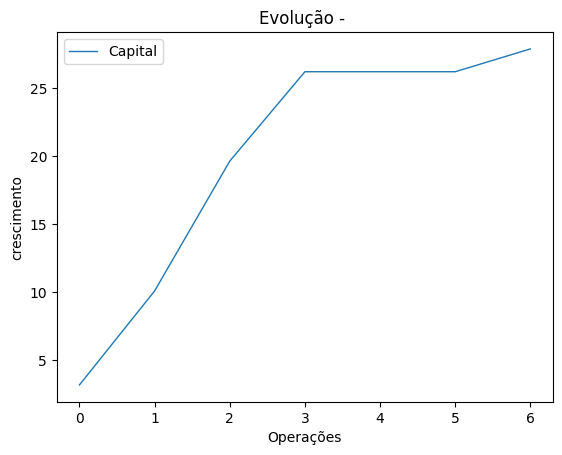

In [34]:
# Defina uma função para carregar e executar o modelo treinado
def run_trained_model(model_path, data, window_size):
    trader = AI_Trader(window_size)
    trader.model = tf.keras.models.load_model(model_path)

    state = state_creator(data, 0, window_size + 1)
    quant_operacoes=0
    operacoes_lucro=0
    operacoes_prejuizo=0
    total_profit = 0
    ganho=0
    perda=0
    trading_diario=0
    trader.inventory.clear()
    trader.inventory = []

    profit_diario = []
    profit_diario_valor=[]
    gt = {'total_profit': []}

    for t in tqdm(range(len(data) - 1)):
        action = trader.trade(state)
        next_state = state_creator(data, t + 1, window_size + 1)

        # Sem ação
        if action == 0:
          # Apenas um print e Recompensa = 0
          print(" - Sem ação | Total de papeis no portfolio = ", len(trader.inventory))

        # Compra
        if action == 1:
          # Recompensa = 0

          # Adicionamos a ação comprada na array de portfolio
          trader.inventory.append(data[t])

          print(" - AI Trader Comprou: ", stock_price_format(data[t]))

        # Venda (Deve possuir ações no portfolio)
        elif action == 2 and len(trader.inventory) > 0:

          quant_operacoes+=1

          # Remove última ação do portfólio e a retorna
          buy_price = trader.inventory.pop(0)

          total_profit += data[t] - buy_price # Soma ao lucro/prejuízo total

          if (data[t] - buy_price > 0):
            operacoes_lucro+=1
            ganho+=((data[t]-buy_price)/buy_price)*100
          else:
            operacoes_prejuizo+=1
            perda+=((data[t]-buy_price)/buy_price)*100

          trading_diario=((data[t]-buy_price)/buy_price)*100

          taxa_acerto=(operacoes_lucro/quant_operacoes)*100
          taxa_erro=(operacoes_prejuizo/quant_operacoes)*100

          gt['total_profit'].append(ganho)

          print(" - AI Trader Vendeu: ", stock_price_format(data[t]), " - Lucro: " + stock_price_format(data[t] - buy_price) )
        state = next_state

        if t == data_samples - 1 or data.index[t].day != data.index[t+1].day:
          profit_diario.append(trading_diario)
          profit_diario_valor.append(total_profit)
          trading_diario=0
          total_profit=0


    plt.figure()
    plt.plot(gt['total_profit'],linewidth=1)
    plt.xlabel('Operações')
    plt.ylabel('crescimento')
    plt.title("Evolução - ")
    plt.legend(['Capital'])

    destination_path = '/content/drive/My Drive/Arquivos H5/Resultado.png'
    plt.savefig(destination_path)
    return total_profit, profit_diario, taxa_acerto, taxa_erro, ganho, perda, profit_diario_valor
#fazer o professo de depuração, sobre os dias em porcentagem, taxa de acerto e taxa de erro, tempo de treinamento da rede, total profit, (criar mais duas variveis, ganho e perda, em porcentagem)
# Caminho do modelo no seu Google Drive
model_path = "/content/drive/My Drive/Arquivos H5/ai_trader_2.h5"  # Substitua pelo caminho correto

# Exemplo de uso
new_data = dataset_loader("PETR4.SA", "2023-01-01", "2023-02-20")  # Carrega novos dados

inicio = time.time()

print(model_path)
# Executa o modelo treinado nos novos dados
profit, profit_diario, taxa_acerto, taxa_erro, ganho, perda, profit_diario_valor = run_trained_model(model_path, new_data, window_size)

fim = time.time()

tempo_execucao=fim - inicio

#Print do tempo que demorou para rodar a parte específica do código
print(f"Tempo de Execucao: {tempo_execucao} segundos")
print(f"Taxa de Acerto: {taxa_acerto} %")
print(f"Taxa de Erro: {taxa_erro} %")
print(f"Ganho: {ganho} %")
print(f"Perda: {abs(perda)} %")
print(f"payoff: {ganho/abs(perda)}")
print(f"Lucro Total: {profit}")
print(f"Profit Diario %: {profit_diario}")
print(f"Profit Diario Valor: {profit_diario_valor}")
